In [1]:
%matplotlib inline

In [2]:
from fabric import api as fapi
from fabric import network as fnet
from fabric import state as fstate

import matplotlib.pyplot as plt

In [3]:
fapi.env.user = 'cc'
fapi.env.host_string = '129.114.109.207'

# Setup

## Intercoolr

https://github.com/coolr-hpc/intercoolr

In [4]:
with fapi.quiet():
    fapi.run('git clone https://github.com/coolr-hpc/intercoolr.git')
    fapi.run('cd intercoolr && make all')

In [5]:
print(fapi.run('./intercoolr/etrace2 -h', quiet=True))

Usage: etrace2 [options] [command]

[Options]
	-i sec : interval
	-t sec : timeout
	-o filename : output filename
	-r : relative time, instead of epoch

[usage examples]

# spawn your program and print energy consumption 
$ ./etrace2 your_program

# also print power consumption every 0.5 sec
$ ./etrace2 -i 0.5  your_program

# just print power consumption every 1sec for 10sec
$ ./etrace2 -i 1.0 -t 10


## Stress

http://people.seas.harvard.edu/~apw/stress/

In [6]:
with fapi.quiet():
    fapi.run('curl http://people.seas.harvard.edu/~apw/stress/stress-1.0.4.tar.gz | tar xz')
    fapi.run('cd stress-1.0.4 && ./configure && make && sudo make install')

In [7]:
print(fapi.run('stress --help', quiet=True))

`stress' imposes certain types of compute stress on your system

Usage: stress [OPTION [ARG]] ...
 -?, --help         show this help statement
     --version      show version statement
 -v, --verbose      be verbose
 -q, --quiet        be quiet
 -n, --dry-run      show what would have been done
 -t, --timeout N    timeout after N seconds
     --backoff N    wait factor of N microseconds before work starts
 -c, --cpu N        spawn N workers spinning on sqrt()
 -i, --io N         spawn N workers spinning on sync()
 -m, --vm N         spawn N workers spinning on malloc()/free()
     --vm-bytes B   malloc B bytes per vm worker (default is 256MB)
     --vm-stride B  touch a byte every B bytes (default is 4096)
     --vm-hang N    sleep N secs before free (default none, 0 is inf)
     --vm-keep      redirty memory instead of freeing and reallocating
 -d, --hdd N        spawn N workers spinning on write()/unlink()
     --hdd-bytes B  write B bytes per hdd worker (default is 1GB)

Example: s

# Running

In [8]:
def etrace(cmd, extra=''):
    return './intercoolr/etrace2 {} {}'.format(extra, cmd)

In [9]:
cmd = etrace('sleep 5')
print(cmd)
stdout = fapi.run(cmd, quiet=True)
print(stdout)

./intercoolr/etrace2  sleep 5
# ETRACE2_VERSION=0.1
# ELAPSED=4.990521
# ENERGY=631.490296
# ENERGY_SOCKET0=182.429200
# ENERGY_DRAM0=126.085999
# ENERGY_SOCKET1=190.040161
# ENERGY_DRAM1=134.287414


In [10]:
stdout = fapi.run(etrace('sleep 10'), quiet=True)
print(stdout)

# ETRACE2_VERSION=0.1
# ELAPSED=9.990736
# ENERGY=1264.784241
# ENERGY_SOCKET0=364.946228
# ENERGY_DRAM0=252.321167
# ENERGY_SOCKET1=379.966370
# ENERGY_DRAM1=268.894165


In [11]:
def stress(t: int, cpu=None, memory=None, extra=''):
    cmd = 'stress --timeout {}s'.format(t)
    if cpu:
        cmd += ' --cpu {}'.format(cpu)
    if memory:
        cmd += ' --vm {}'.format(memory)
    if extra:
        cmd += ' {}'.format(extra)
    return cmd

In [12]:
def skim_trace(output):
    trace = {}
    other = []
    for line in output.splitlines():
        if line.startswith('# E'):
            key, value = line.split('=')
            key = key.lower().strip(' #')
            value = float(value)
            trace[key] = value
        else:
            other.append(line)
            
    return trace, '\n'.join(other)

In [13]:
cmd = etrace(stress(5, 48))
print(cmd)
stdout = fapi.run(cmd, quiet=True)
trace, remainder = skim_trace(stdout)
print(remainder)
trace

./intercoolr/etrace2  stress --timeout 5s --cpu 48
stress: info: [66153] dispatching hogs: 48 cpu, 0 io, 0 vm, 0 hdd
stress: info: [66153] successful run completed in 5s


{'elapsed': 4.992135,
 'energy': 1337.474059,
 'energy_dram0': 127.157227,
 'energy_dram1': 134.39502,
 'energy_socket0': 529.417358,
 'energy_socket1': 547.892578,
 'etrace2_version': 0.1}

In [14]:
cmd = etrace(stress(5, memory=4))
print(cmd)
stdout = fapi.run(cmd, quiet=True)
skim_trace(stdout)[0]

./intercoolr/etrace2  stress --timeout 5s --vm 4


{'elapsed': 4.991194,
 'energy': 949.715758,
 'energy_dram0': 226.442932,
 'energy_dram1': 172.585205,
 'energy_socket0': 308.288757,
 'energy_socket1': 244.126282,
 'etrace2_version': 0.1}

# Stats

## En bloc

In [15]:
runs = []
t = 5
for n_cpu in [0, 1, 2, 6, 12, 18, 24, 36, 48, 60]:
    if n_cpu > 0:
        cmd = stress(t, n_cpu)
    else:
        cmd = 'sleep {}'.format(t)
    stdout = fapi.run(etrace(cmd), quiet=True)
    trace, _ = skim_trace(stdout)
    trace['n_cpu'] = n_cpu
    runs.append(trace)

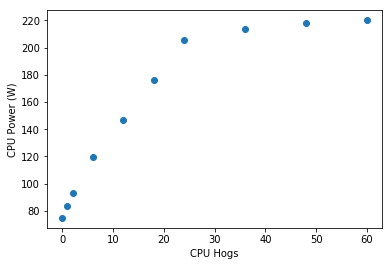

In [16]:
def socket_power(run):
    return (run['energy_socket0'] + run['energy_socket1']) / run['elapsed']

f, ax = plt.subplots()
workers, sockets_power = zip(*((r['n_cpu'], socket_power(r)) for r in runs))
ax.plot(workers, sockets_power, 'o')
ax.set_xlabel('CPU Hogs')
ax.set_ylabel('CPU Power (W)')

## With timepoints

In [17]:
runs = {}
for n_cpu in [1, 6, 24, 100]:
    runs[n_cpu] = fapi.run(etrace(stress(10, n_cpu), extra='-i 0.25'), quiet=True)

In [18]:
def extract_values(out):
    points = []
    for line in out.splitlines():
        try:
            values = [float(x) for x in line.split()]
        except ValueError:
            continue
        if len(values) != 3:
            continue
        points.append(values)
    return points

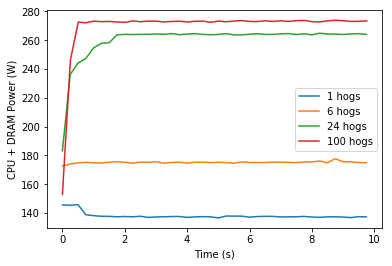

In [19]:
f, ax = plt.subplots()

for n_cpu, run in runs.items():
    time_points = extract_values(run)
    t, p, e = zip(*time_points)
    trel = [tx - t[0] for tx in t]
    
    ax.plot(trel, p, label='{} hogs'.format(n_cpu))
    
ax.set_xlabel('Time (s)')
ax.set_ylabel('CPU + DRAM Power (W)')
ax.legend()

In [20]:
fnet.disconnect_all()

Disconnecting from 129.114.109.207... done.
